In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

In [2]:
def age_to_days(input_string):
    # Define regular expressions to match years and days
    years_regex = r'(\d+)\s*years?'
    days_regex = r'(\d+)\s*days?'

    # Search for years and days in the input string
    years_match = re.search(years_regex, input_string)
    days_match = re.search(days_regex, input_string)

    # Initialize variables to store years and days
    years = 0
    days = 0

    if years_match:
        years = int(years_match.group(1))
    if days_match:
        days = round(int(days_match.group(1)) / 365, 2)

    if years == 0 and days == 0:
        return np.nan

    total = years + days

    return total

In [3]:
def plot_barh(df, selected_columns = ["Grade","Gender", "Primary_Diagnosis", "Race"]):
    for column in selected_columns:
        column_counts = df[column].value_counts()
        column_counts.plot(kind='barh')
        plt.title(column)
        plt.show()

In [4]:
mutatations = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

# To make the data more readable, we will replace the 'MUTATED' and 'NOT_MUTATED' values with True and False
mutatations.replace('MUTATED', 1, inplace=True)
mutatations.replace('NOT_MUTATED', 0, inplace=True)

# Along with the 'MUTATED' and 'NOT_MUTATED' values, we will also found that Grade and Project are redundant columns so we will drop the project column
mutatations.drop(columns=['Project'], inplace=True)

# We will also drop the Case_ID column as it is not useful for our analysis
mutatations.drop(columns=['Case_ID'], inplace=True)

# Interpret the age_at_diagnosis column as a int to be able to perform calculations
mutatations['Age_at_diagnosis'] = mutatations['Age_at_diagnosis'].apply(age_to_days)

mutatations.describe()
mutatations

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\3083296509.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mutatations.replace('NOT_MUTATED', 0, inplace=True)


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,51.30,"Oligodendroglioma, NOS",white,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,LGG,Male,38.72,Mixed glioma,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,LGG,Male,35.17,"Astrocytoma, NOS",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LGG,Female,32.78,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,LGG,Male,31.51,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,77.89,Glioblastoma,white,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
858,GBM,Male,85.18,Glioblastoma,white,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
859,GBM,Female,77.49,Glioblastoma,white,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
860,GBM,Male,63.33,Glioblastoma,white,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
# By analysing the data, we found that some information was marked as "--" and we decided to replace it with NaN for better analysis
mutatations.replace('--', np.nan, inplace=True)

missing = mutatations.loc[mutatations["Gender"].isnull() & mutatations["Age_at_diagnosis"].isnull() & mutatations["Primary_Diagnosis"].isnull() & mutatations["Race"].isnull()]
print(missing)
print("Missing:", len(missing))
# We found that there were 4 rows null in each of the columns, so we decided to remove them from the data because filling them with the mean or median would not be accurate because the data is categorical
# and we would be filling them possibilites with the same value and completly different mutation data
mutatations.drop(index=missing.index, inplace=True)

# We will now fill the missing values in the 'Age_at_diagnosis' column with the median value for the specific row that has only that field missing
missing_only_age = mutatations.loc[mutatations["Age_at_diagnosis"].isnull()]

# To fill the missing data more accurately, we will group the data by 'Grade', 'Gender', 'Primary_Diagnosis' and 'Race' and calculate the mean of the 'Age_at_diagnosis' column
grouped_data = mutatations.groupby(['Grade', 'Gender', 'Primary_Diagnosis', 'Race'])['Age_at_diagnosis'].mean()


    Grade Gender  Age_at_diagnosis Primary_Diagnosis Race  IDH1  TP53  ATRX  \
41    LGG    NaN               NaN               NaN  NaN     1     1     1   
671   GBM    NaN               NaN               NaN  NaN     0     0     0   
706   GBM    NaN               NaN               NaN  NaN     0     0     0   
794   GBM    NaN               NaN               NaN  NaN     0     0     0   

     PTEN  EGFR  ...  FUBP1  RB1  NOTCH1  BCOR  CSMD3  SMARCA4  GRIN2A  IDH2  \
41      0     0  ...      0    0       0     0      0        0       0     0   
671     0     0  ...      0    0       0     0      0        0       0     0   
706     1     0  ...      0    0       0     0      0        0       0     0   
794     0     1  ...      0    0       0     0      0        0       0     0   

     FAT4  PDGFRA  
41      0       0  
671     0       0  
706     0       0  
794     0       0  

[4 rows x 25 columns]
Missing: 4


In [6]:
grouped_data = grouped_data.to_frame().reset_index()
for idx, row in missing_only_age.iterrows():
    matched_rows = grouped_data.loc[(grouped_data["Grade"] == row["Grade"]) &
                                    (grouped_data["Gender"] == row["Gender"]) &
                                    (grouped_data["Primary_Diagnosis"] == row["Primary_Diagnosis"]) &
                                    (grouped_data["Race"] == row["Race"])]

In [7]:
missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])
mutatations.update(missing_only_age)
mutatations

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\3960743357.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\3960743357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_only_age['Age_at_diagnosis'] = int(matched_rows["Age_at_diagnosis"])


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,Male,51.30,"Oligodendroglioma, NOS",white,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,LGG,Male,38.72,Mixed glioma,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,LGG,Male,35.17,"Astrocytoma, NOS",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LGG,Female,32.78,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,LGG,Male,31.51,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,Female,77.89,Glioblastoma,white,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
858,GBM,Male,85.18,Glioblastoma,white,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
859,GBM,Female,77.49,Glioblastoma,white,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
860,GBM,Male,63.33,Glioblastoma,white,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


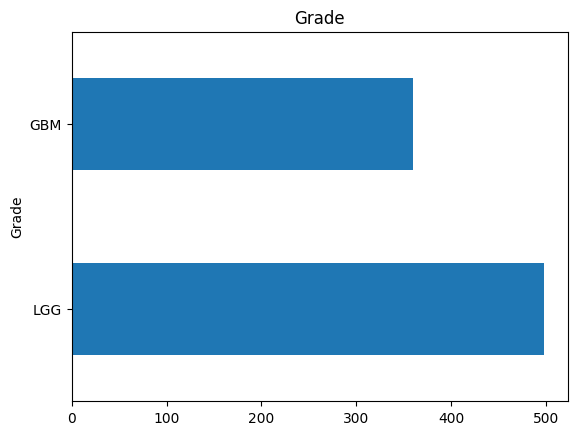

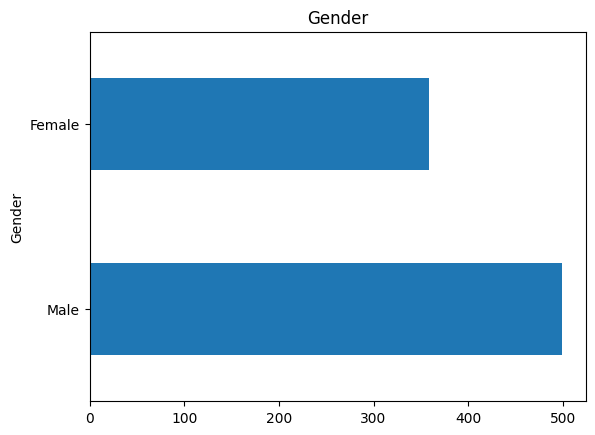

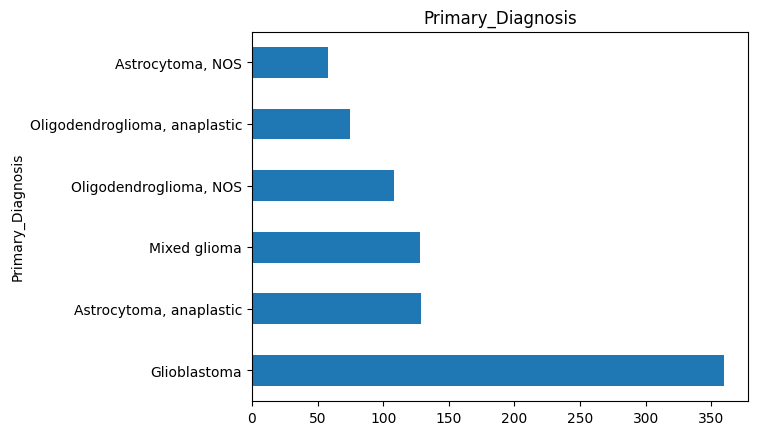

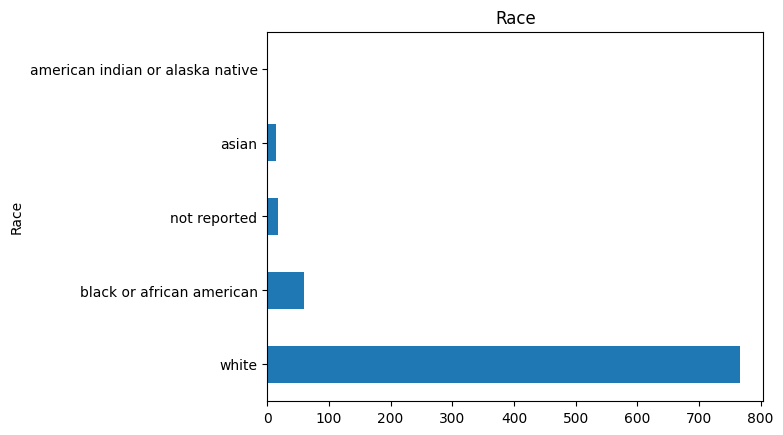

In [8]:
plot_barh(mutatations)

In [9]:
# As we can see from the pie graph there are some values that are not reported, we will now fill them with the most common value for the specific row
not_reported_race = mutatations.loc[mutatations["Race"] == "not reported"]

for idx, row in not_reported_race.iterrows():
    most_common_race = mutatations.loc[(mutatations["Grade"] == row["Grade"]) &
                                   (mutatations["Gender"] == row["Gender"]) &
                                   (mutatations["Primary_Diagnosis"] == row["Primary_Diagnosis"])]["Race"].value_counts().idxmax()
    not_reported_race["Race"] = most_common_race
mutatations.update(not_reported_race)

C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\566938535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_reported_race["Race"] = most_common_race
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\566938535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_reported_race["Race"] = most_common_race
C:\Users\Cristiano\AppData\Local\Temp\ipykernel_3624\566938535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

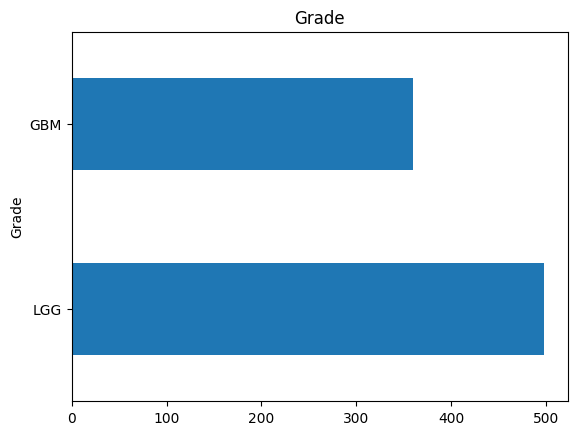

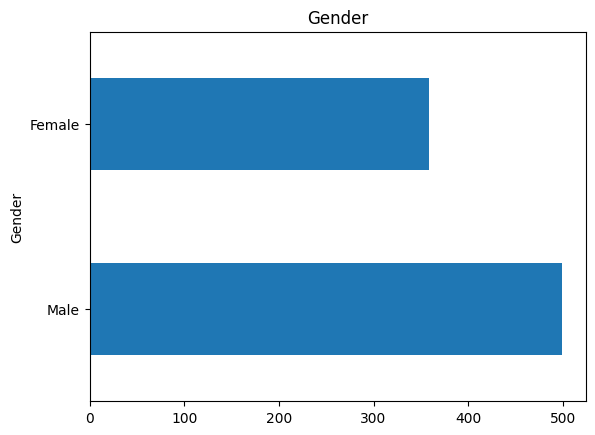

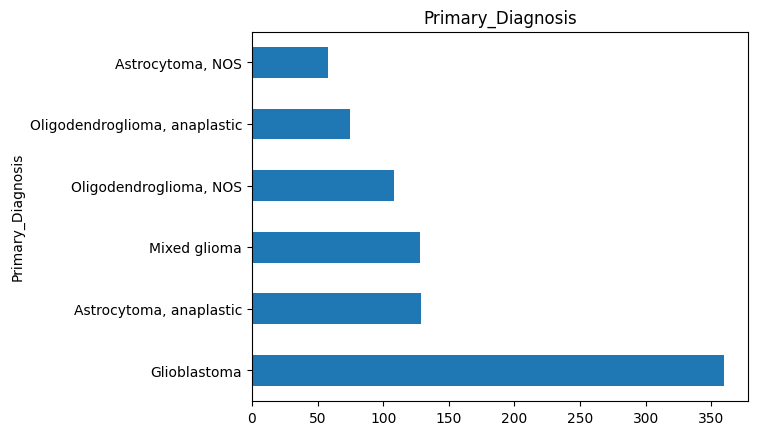

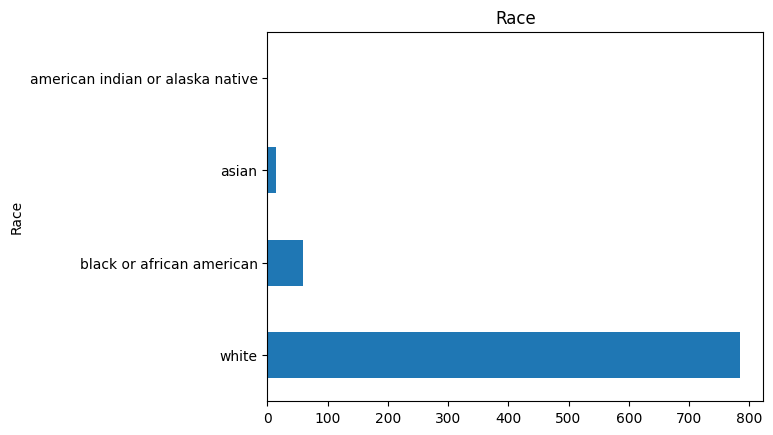

In [10]:
# As we can see now we have a much cleaner dataset with no missing values that is ready for further analysis
plot_barh(mutatations)

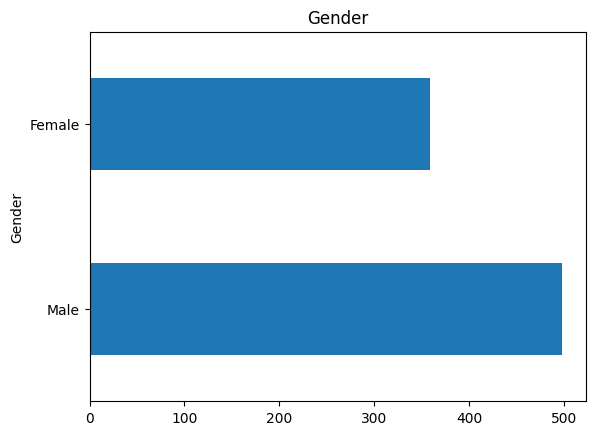

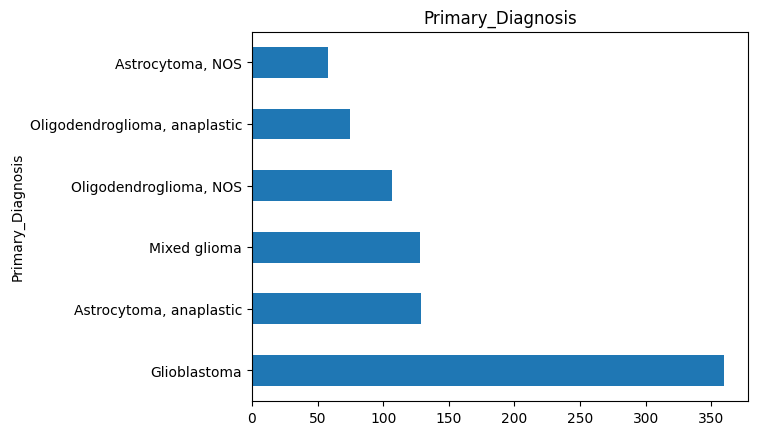

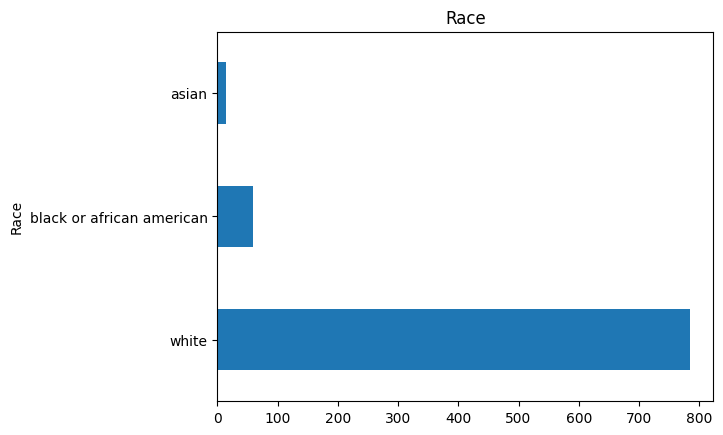

In [11]:
# As we can see there is a very small number of 'american indian or alaska native' values, so we decided to remove them from the dataset
mutatations.drop(index=mutatations[mutatations["Race"] == "american indian or alaska native"].index, inplace=True)
selected_columns = ["Gender", "Primary_Diagnosis", "Race"]

for column in selected_columns:
    column_counts = mutatations[column].value_counts()
    column_counts.plot(kind='barh')
    plt.title(column)
    plt.show()

In [12]:
# Now that the data is cleaned, we will convert the categorical data into numerical data using one-hot encoding or label encoding
# We decided to use label enconding for a smaller dataset

## One-hot encoding
# mutatations = pd.get_dummies(mutatations, drop_first=True)

## Label encoding
from sklearn.preprocessing import LabelEncoder

# To understand what the values represent, we will create a dictionary that will map the values to the original values
data_dictionary = {}

# Initialize LabelEncoder
label_encoder = LabelEncoder()
mutatations["Grade"] = label_encoder.fit_transform(mutatations["Grade"])
data_dictionary.update({"Grade" : dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))})

mutatations["Gender"] = label_encoder.fit_transform(mutatations["Gender"])
data_dictionary.update({"Gender" : dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))})

mutatations["Primary_Diagnosis"] = label_encoder.fit_transform(mutatations["Primary_Diagnosis"])
data_dictionary.update({"Primary_Diagnosis" : dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))})

mutatations["Race"] = label_encoder.fit_transform(mutatations["Race"])
data_dictionary.update({"Race" : dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))})
print(data_dictionary)

# Now that we used the primary diagnosis column to fill the missing values in the age column, we will drop the primary diagnosis column
# Because it could introduce data leakage in the model because it is closely related to the grade column
mutatations.drop(columns=['Primary_Diagnosis'], inplace=True)

# Now that the data is cleaned and encoded, we will save it to a new csv file
mutatations.to_csv('TCGA_GBM_LGG_Mutations_clean.csv', index=False)
mutatations

{'Grade': {'GBM': 0, 'LGG': 1}, 'Gender': {'Female': 0, 'Male': 1}, 'Primary_Diagnosis': {'Astrocytoma, NOS': 0, 'Astrocytoma, anaplastic': 1, 'Glioblastoma': 2, 'Mixed glioma': 3, 'Oligodendroglioma, NOS': 4, 'Oligodendroglioma, anaplastic': 5}, 'Race': {'asian': 0, 'black or african american': 1, 'white': 2}}


,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
858,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
859,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
